In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

In [30]:
# Read Data Files
cardio_dataset_raw = pd.read_csv("../input/cardio_train.csv",sep=";")

print("Dataset memiliki " + str(len(cardio_dataset_raw)) + " baris dan " + str(len(cardio_dataset_raw.columns)) + " kolom")
print()
print(cardio_dataset_raw.head())

Dataset memiliki 70000 baris dan 13 kolom

   id    age  gender  height  weight   ...    gluc  smoke  alco  active  cardio
0   0  18393       2     168    62.0   ...       1      0     0       1       0
1   1  20228       1     156    85.0   ...       1      0     0       1       1
2   2  18857       1     165    64.0   ...       1      0     0       0       1
3   3  17623       2     169    82.0   ...       1      0     0       1       1
4   4  17474       1     156    56.0   ...       1      0     0       0       0

[5 rows x 13 columns]


In [31]:
# Cek semua deskripsi label pada dataset

for i in range(len(cardio_dataset_raw.columns)):
    print(cardio_dataset_raw[cardio_dataset_raw.columns[i]].describe())
    print()

count    70000.000000
mean     49972.419900
std      28851.302323
min          0.000000
25%      25006.750000
50%      50001.500000
75%      74889.250000
max      99999.000000
Name: id, dtype: float64

count    70000.000000
mean     19468.865814
std       2467.251667
min      10798.000000
25%      17664.000000
50%      19703.000000
75%      21327.000000
max      23713.000000
Name: age, dtype: float64

count    70000.000000
mean         1.349571
std          0.476838
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: gender, dtype: float64

count    70000.000000
mean       164.359229
std          8.210126
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

count    70000.000000
mean        74.205690
std         14.395757
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: w

In [33]:
# Cek semua label, lihat apakah terdapat NULL
for i in range(len(cardio_dataset_raw.columns)):
    print("Label " + cardio_dataset_raw.columns[i] + " memiliki " + str(cardio_dataset_raw[cardio_dataset_raw.columns[i]].isnull().sum()) + " data kosong")

Label id memiliki 0 data kosong
Label age memiliki 0 data kosong
Label gender memiliki 0 data kosong
Label height memiliki 0 data kosong
Label weight memiliki 0 data kosong
Label ap_hi memiliki 0 data kosong
Label ap_lo memiliki 0 data kosong
Label cholesterol memiliki 0 data kosong
Label gluc memiliki 0 data kosong
Label smoke memiliki 0 data kosong
Label alco memiliki 0 data kosong
Label active memiliki 0 data kosong
Label cardio memiliki 0 data kosong


In [34]:
# Cek data outlier pada setiap label menggunakan IQR (InterQuartile Range)

copy_of_cardio_dataset_raw = cardio_dataset_raw.copy()

# Menentukan label apa saja yang ingin dicek outliernya. Yang dicek hanyalah label yang bersifat numerical (bukan categorical maupun identifier)
check_outlier_column = ['age','height','weight','ap_hi','ap_lo']

row_with_outlier = []

# Cek IQR pada semua label
Q1 = copy_of_cardio_dataset_raw.quantile(0.25)
Q3 = copy_of_cardio_dataset_raw.quantile(0.75)

IQR = Q3 - Q1
rangeBawah = (Q1 - 1.5 * IQR) // 1
rangeAtas = (Q3 + 1.5 * IQR) // 1

for i in range(len(check_outlier_column)):
    countOutlier = 0
    for j in range(len(copy_of_cardio_dataset_raw)):
        
        #Cek apakah data lebih kecil dari Q1 - 1.5 * IQR
        if(copy_of_cardio_dataset_raw.loc[j][check_outlier_column[i]] < rangeBawah[check_outlier_column[i]]): 
            countOutlier = countOutlier + 1
            row_with_outlier.append(j)
        
        #Cek apakah data lebih besar dari Q3 + 1.5 * IQR
        elif(copy_of_cardio_dataset_raw.loc[j][check_outlier_column[i]] > rangeAtas[check_outlier_column[i]]):
            countOutlier = countOutlier + 1
            row_with_outlier.append(j)
            
    print("Label " + check_outlier_column[i] + " memiliki " + str(countOutlier) + " data outlier")

Label age memiliki 4 data outlier
Label height memiliki 490 data outlier
Label weight memiliki 1810 data outlier
Label ap_hi memiliki 1435 data outlier
Label ap_lo memiliki 4632 data outlier


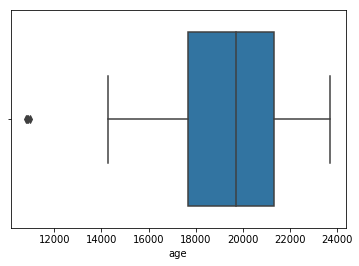

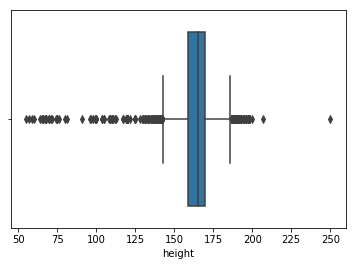

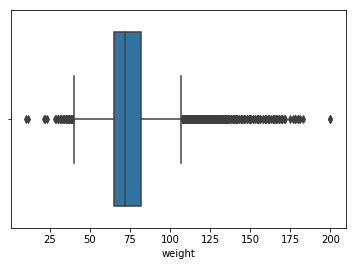

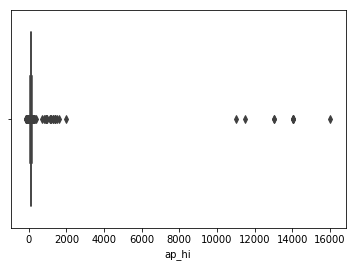

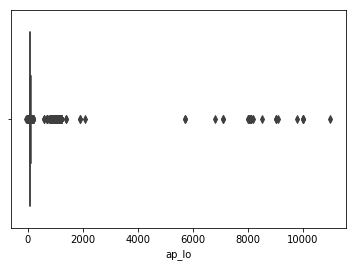

In [41]:
# Cek outlier menggunakan boxplot
import seaborn as sns
import matplotlib.pyplot as plt
for col in check_outlier_column:
    sns.boxplot(x=copy_of_cardio_dataset_raw[col])
    plt.show()

In [35]:
#Logically, ap_hi (sistole) harus lebih tinggi dari ap_lo (diastole)
row_with_error = []

#Cek apakah ada tekanan darah yang error
for i in range(len(copy_of_cardio_dataset_raw)):
    if(copy_of_cardio_dataset_raw.loc[i]['ap_hi'] < copy_of_cardio_dataset_raw.loc[i]['ap_lo']):
        row_with_error.append(i)
    
print("Dataset memiliki " + str(len(row_with_error)) + " yang memiliki ap_lo yang lebih tinggi dari ap_hi")

Dataset memiliki 1234 yang memiliki ap_lo yang lebih tinggi dari ap_hi


In [43]:
# Menggabungkan row_with_outlier dengan row_with_error
row_with_errors = []
row_with_errors = row_with_errors + row_with_outlier
row_with_errors = row_with_errors + row_with_error

# Cek row yang memiliki outlier & error, hapus row duplikasi, kemudian sort row dari terbesar ke terkecil
row_with_errors = list(dict.fromkeys(row_with_errors))

# Sort row dari terbesar ke terkecil
for i in range(len(row_with_errors)):
    swap = i + np.argmax(row_with_errors[i:])
    (row_with_errors[i], row_with_errors[swap]) = (row_with_errors[swap], row_with_errors[i])

#print(row_with_errors)
print("Secara total, terdapat " + str(len(row_with_errors)) + " baris yang harus dibersihkan")

Secara total, terdapat 7470 baris yang harus dibersihkan


In [52]:
cleaned_cardio_dataset = copy_of_cardio_dataset_raw.copy().drop(row_with_errors, axis=0)

#Reset row index
cleaned_cardio_dataset = cleaned_cardio_dataset.reset_index()

print("Dataset yang baru memiliki " + str(len(cleaned_cardio_dataset)) + " baris dan " + str(len(cleaned_cardio_dataset.columns)) + " kolom")
print()
print(cleaned_cardio_dataset.head(5))


Dataset yang baru memiliki 62530 baris dan 14 kolom

   index  id    age  gender  height   ...    gluc  smoke  alco  active  cardio
0      0   0  18393       2     168   ...       1      0     0       1       0
1      1   1  20228       1     156   ...       1      0     0       1       1
2      2   2  18857       1     165   ...       1      0     0       0       1
3      3   3  17623       2     169   ...       1      0     0       1       1
4      5   8  21914       1     151   ...       2      0     0       0       0

[5 rows x 14 columns]


In [57]:
#Label height dan weight dapat digabung, menghasilkan BMI (Body Mass Index)
bmi = []

# BMI List (for 18 years older, male and female):                      
# Underweight = <18.5            -> 0
# Normal      = 18.5 - 24.9      -> 1
# Overweight  = 25 - 29.9        -> 2
# Obesity     = >30              -> 3

def convert_bmi_to_list(list_bmi):
    for i in range(len(list_bmi)):
        if(list_bmi[i] < 18.5):
            list_bmi[i] = 0 #Underweight
        elif(list_bmi[i] >= 18.5 and list_bmi[i] < 25):
            list_bmi[i] = 1 #Normal
        elif(list_bmi[i] >= 25 and list_bmi[i] < 30):
            list_bmi[i] = 2 #Overweight
        elif(list_bmi[i] >= 30):
            list_bmi[i] = 3 #Obesity
    return list_bmi

for i in range(len(cleaned_cardio_dataset)):
    bmi.append(cleaned_cardio_dataset.loc[i]['weight'] / (cleaned_cardio_dataset.loc[i]['height'] / 100) ** 2)
            
convert_bmi_to_list(bmi)

#print(bmi)

#Tambah kolom baru, yaitu bmi yang merupakan gabungan dari kolom weight dan kolom height
cleaned_cardio_dataset['bmi'] = bmi

print(cleaned_cardio_dataset.head(5))

   index  id    age  gender  height ...   smoke  alco  active  cardio  bmi
0      0   0  18393       2     168 ...       0     0       1       0    1
1      1   1  20228       1     156 ...       0     0       1       1    3
2      2   2  18857       1     165 ...       0     0       0       1    1
3      3   3  17623       2     169 ...       0     0       1       1    2
4      5   8  21914       1     151 ...       0     0       0       0    2

[5 rows x 15 columns]


In [64]:
#Label ap_hi dan ap_lo dapat digabung, menghasilkan blood pressure
bp = []

# Blood Pressure List: (based on bloodpressureUK)
# ap_hi < 90 or ap_lo < 60 : Low Blood Pressure                       -> 0
# ap_hi >= 90 and ap_hi < 140 and ap_lo >= 60 and ap_lo < 90 : Normal -> 1
# ap_hi >= 140 or ap_lo >= 90 : High Blood Pressure                   -> 2

for i in range(len(cleaned_cardio_dataset)):
    if(cleaned_cardio_dataset.loc[i]['ap_hi'] < 90 or cleaned_cardio_dataset.loc[i]['ap_lo'] < 60):
        bp.append(0) #Low BP
    elif(cleaned_cardio_dataset.loc[i]['ap_hi'] >= 90 and cleaned_cardio_dataset.loc[i]['ap_hi'] < 140 and cleaned_cardio_dataset.loc[i]['ap_lo'] >= 60 and cleaned_cardio_dataset.loc[i]['ap_lo'] < 90):
        bp.append(1) #Normal BP
    elif(cleaned_cardio_dataset.loc[i]['ap_hi'] >= 140 and cleaned_cardio_dataset.loc[i]['ap_lo'] >= 90):
        bp.append(2) #High BP
    else:
        bp.append(-1) #Error
        
cleaned_cardio_dataset['bp'] = bp

print(cleaned_cardio_dataset.head(5))

   index  id    age  gender  height ...  alco  active  cardio  bmi  bp
0      0   0  18393       2     168 ...     0       1       0    1   1
1      1   1  20228       1     156 ...     0       1       1    3   2
2      2   2  18857       1     165 ...     0       0       1    1   1
3      3   3  17623       2     169 ...     0       1       1    2   2
4      5   8  21914       1     151 ...     0       0       0    2   1

[5 rows x 16 columns]


In [65]:
#Cek apakah terdapat bp yang error
row_with_bp_error = []

for i in range(len(cleaned_cardio_dataset)):
    if(cleaned_cardio_dataset.loc[i]['bp'] == -1):
        row_with_bp_error.append(i)
        
print("Terdapat " + str(len(row_with_bp_error)) + " baris yang memiliki bp error")

Terdapat 8749 baris yang memiliki bp error


In [67]:
# Cek row yang memiliki bp error, hapus row duplikasi, kemudian sort row dari terbesar ke terkecil
row_with_bp_error = list(dict.fromkeys(row_with_bp_error))

# Sort row dari terbesar ke terkecil
for i in range(len(row_with_bp_error)):
    swap = i + np.argmax(row_with_bp_error[i:])
    (row_with_bp_error[i], row_with_bp_error[swap]) = (row_with_bp_error[swap], row_with_bp_error[i])

#print(row_with_bp_error)

In [68]:
cleaned_cardio_dataset = cleaned_cardio_dataset.drop(row_with_bp_error, axis=0)

#Reset row index
cleaned_cardio_dataset = cleaned_cardio_dataset.reset_index()

print("Dataset yang baru memiliki " + str(len(cleaned_cardio_dataset)) + " baris dan " + str(len(cleaned_cardio_dataset.columns)) + " kolom")
print()
print(cleaned_cardio_dataset.head(5))

Dataset yang baru memiliki 53781 baris dan 17 kolom

   level_0  index  id    age  gender ...  alco  active  cardio  bmi  bp
0        0      0   0  18393       2 ...     0       1       0    1   1
1        1      1   1  20228       1 ...     0       1       1    3   2
2        2      2   2  18857       1 ...     0       0       1    1   1
3        3      3   3  17623       2 ...     0       1       1    2   2
4        4      5   8  21914       1 ...     0       0       0    2   1

[5 rows x 17 columns]


Pearson’s Correlation Coefficient helps you find out the relationship between two quantities. It gives you the measure of the strength of association between two variables. The value of Pearson’s Correlation Coefficient can be between -1 to +1.

1 means that they are highly correlated and 0 means no correlation. -1 means that there is a negative correlation. Think of it as an inverse proportion.

https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/

<function matplotlib.pyplot.show(*args, **kw)>

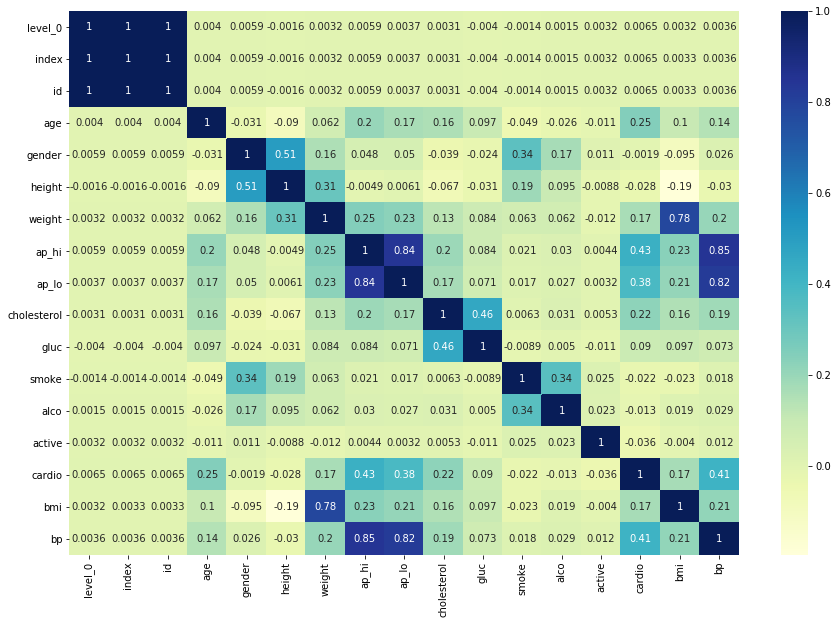

In [69]:
sns.heatmap(cleaned_cardio_dataset.corr(),annot=True,cmap='YlGnBu')
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show

Kami akan mengambil cardio sebagai label, dan menentukan fitur berdasarkan plotting correlation dengan metode Pearson di atas. Dari plotting tersebut, kami memutuskan untuk memilih age, weight, ap_hi, ap_lo, dan chole

In [97]:
final_cardio = cleaned_cardio_dataset.copy().drop(columns=['level_0','index','id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo'])
final_cardio.head(5)

,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
0,1,1,0,0,1,0,1,1
1,3,1,0,0,1,1,3,2
2,3,1,0,0,0,1,1,1
3,1,1,0,0,1,1,2,2
4,2,2,0,0,0,0,2,1


In [98]:
final_cardio.describe()

,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
count,53781.000000,53781.000000,53781.000000,53781.000000,53781.000000,53781.000000,53781.000000,53781.000000
mean,1.333817,1.213719,0.084640,0.050222,0.805470,0.463286,1.820940,1.229523
std,0.655951,0.560168,0.278347,0.218405,0.395842,0.498655,0.790795,0.420530
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000
max,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000


In [99]:
y_cardio = final_cardio['cardio']
x_cardio = final_cardio.drop('cardio', axis=1)

In [100]:
y_cardio.head(5)

0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64

In [101]:
x_cardio.head(5)

,cholesterol,gluc,smoke,alco,active,bmi,bp
0,1,1,0,0,1,1,1
1,3,1,0,0,1,3,2
2,3,1,0,0,0,1,1
3,1,1,0,0,1,2,2
4,2,2,0,0,0,2,1


In [102]:
x_train, x_test, y_train, y_test = train_test_split(x_cardio, y_cardio, test_size=0.3)

In [103]:
print("Data training {}, data testing {}".format(x_train.shape, x_test.shape))

Data training (37646, 7), data testing (16135, 7)


In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [105]:
for col in x_train.columns:
    x_train[col] = scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
x_train.head()

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site

,cholesterol,gluc,smoke,alco,active,bmi,bp
35579,-0.506857,-0.381729,-0.303856,-0.230996,0.492801,0.223531,-0.545938
654,-0.506857,-0.381729,-0.303856,-0.230996,0.492801,1.489144,-0.545938
29100,-0.506857,-0.381729,-0.303856,-0.230996,-2.029218,-1.042082,1.831709
24164,-0.506857,3.196596,-0.303856,-0.230996,0.492801,-1.042082,-0.545938
44465,-0.506857,-0.381729,-0.303856,-0.230996,0.492801,-1.042082,-0.545938


In [106]:
for col in x_train.columns:
    x_test[col] = scaler.fit_transform(np.array(x_test[col]).reshape(-1,1))
x_test.head()

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site

,cholesterol,gluc,smoke,alco,active,bmi,bp
28719,-0.513697,-0.381077,-0.304610,-0.227501,0.488253,0.233190,-0.545479
42297,-0.513697,1.394969,-0.304610,-0.227501,0.488253,-1.028978,-0.545479
10309,2.511858,3.171015,-0.304610,-0.227501,0.488253,1.495359,1.833251
35289,-0.513697,-0.381077,-0.304610,-0.227501,-2.048117,-1.028978,-0.545479
31895,-0.513697,3.171015,3.282891,-0.227501,0.488253,0.233190,1.833251


In [107]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(x_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [108]:
print("Random Forest Classifier - Accuracy: ", rfc.score(x_test, y_test))
print("Ada Boost Classifier - Accuracy: ", abc.score(x_test, y_test))

Random Forest Classifier - Accuracy:  0.7198636504493338
Ada Boost Classifier - Accuracy:  0.720359466997211


Benchmarking for the Accuracies

In [109]:
np.unique(y_test)

array([0, 1])

In [110]:
((y_train == 0).sum() + (y_test == 0).sum()) / final_cardio.shape[0]

0.5367137093025418

In [111]:
((y_train == 1).sum() + (y_test == 1).sum()) / final_cardio.shape[0]

0.4632862906974582